In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

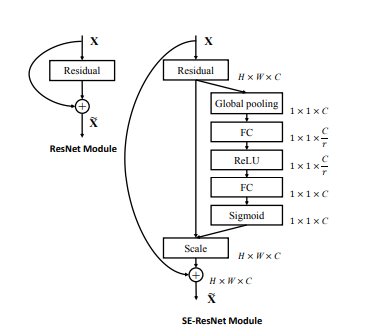

SIN MODULO

In [4]:
from keras.api._v2.keras import layers
import keras
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [5]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

RESNET34

In [6]:
def ResNet34(shape = (32, 32, 3), classes = 4):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [7]:
import numpy as np
train_data = np.load('/content/drive/MyDrive/prubeba_entrega/dataset.npz')
print(train_data.files)
x_train = train_data['x']
y_train = train_data['y']

['x', 'y']


In [8]:
channel = x_train.shape[-1]

In [9]:
# to 32 x 32 x channel
import cv2
real = np.ndarray(shape=(x_train.shape[0], 32, 32, channel))
for i in range(x_train.shape[0]):
    real[i] = cv2.resize(x_train[i], (32, 32)).reshape((32, 32, channel))

In [10]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(real, y_train, test_size=0.2, random_state=42)

In [ ]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [11]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [12]:
#one hot encoding 
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train,num_classes)
y_test = tf.keras.utils.to_categorical(y_test,num_classes)

In [13]:
model = ResNet34()

In [14]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 19, 19, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
batch_size= 64
epochs = 20
history = model.fit(x_train,y_train,batch_size=batch_size*2, epochs=epochs,validation_data=(x_test, y_test),
                      shuffle=True,verbose=1)

Epoch 1/20
8/8 [==============================] - 33s 380ms/step - loss: 2.8741 - accuracy: 0.4313 - val_loss: 9435.9561 - val_accuracy: 0.2417
Epoch 2/20
8/8 [==============================] - 1s 67ms/step - loss: 0.6106 - accuracy: 0.6823 - val_loss: 15514.4863 - val_accuracy: 0.2417
Epoch 3/20
8/8 [==============================] - 1s 70ms/step - loss: 0.4915 - accuracy: 0.7344 - val_loss: 3777.7666 - val_accuracy: 0.2417
Epoch 4/20
8/8 [==============================] - 1s 69ms/step - loss: 0.3690 - accuracy: 0.8458 - val_loss: 408.9799 - val_accuracy: 0.2417
Epoch 5/20
8/8 [==============================] - 1s 70ms/step - loss: 0.2127 - accuracy: 0.9167 - val_loss: 55.2972 - val_accuracy: 0.2417
Epoch 6/20
8/8 [==============================] - 1s 74ms/step - loss: 0.2312 - accuracy: 0.9208 - val_loss: 9.5073 - val_accuracy: 0.2417
Epoch 7/20
8/8 [==============================] - 1s 75ms/step - loss: 0.2124 - accuracy: 0.9146 - val_loss: 2.8646 - val_accuracy: 0.2542
Epoch 8/20
8

In [17]:
#Algortimo de GradCAM para visualizacion
#Author: fchollet
#Libro: Deep Learning with Python (2017)
#Description: How to obtain a class activation heatmap for an image classification model.

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [18]:
etiquetas = np.array([
    'Green',
    'Light',
    'Medium',
    'Dark'])

In [19]:
preprocess_input = tf.keras.applications.xception.preprocess_input

img_array = preprocess_input(get_img_array('cafe.jpg', size=(32,32)))
img_array = img_array.astype('float32')/255.0
mean = np.mean(img_array,axis=(0,1,2,3))
std = np.std(img_array, axis=(0,1,2,3))
img_array = (img_array- mean)/(std+1e-7)
preds1 = model.predict(img_array)
#preds2 = model2.predict(img_array)
print(str(etiquetas[(np.argmax(preds1,axis=1))[0]]))
#print(str(etiquetas[(np.argmax(preds2,axis=1))[0]]))
heatmap1 = make_gradcam_heatmap(img_array, model, 'activation_32')
#heatmap1 = make_gradcam_heatmap(img_array, model, 'add_15')
heatmap1 = cv2.resize(heatmap1,(552,612))

1/1 [==============================] - 1s 1s/step
Dark


In [20]:
print(heatmap1)
plt.show

[[0.91193694 0.91193694 0.91193694 ... 0.31945413 0.31945413 0.31945413]
 [0.91193694 0.91193694 0.91193694 ... 0.31945413 0.31945413 0.31945413]
 [0.91193694 0.91193694 0.91193694 ... 0.31945413 0.31945413 0.31945413]
 ...
 [1.         1.         1.         ... 0.92994565 0.92994565 0.92994565]
 [1.         1.         1.         ... 0.92994565 0.92994565 0.92994565]
 [1.         1.         1.         ... 0.92994565 0.92994565 0.92994565]]


<function matplotlib.pyplot.show(close=None, block=None)>

<function matplotlib.pyplot.show(close=None, block=None)>

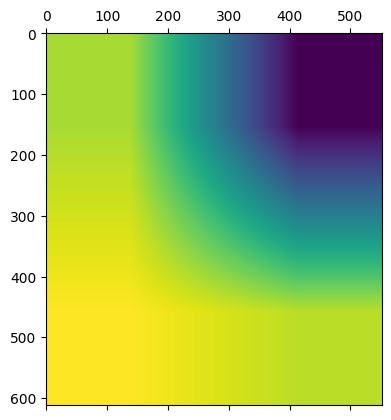

In [21]:
plt.matshow(heatmap1)
plt.show

In [22]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))




<ipython-input-22-271777074253>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


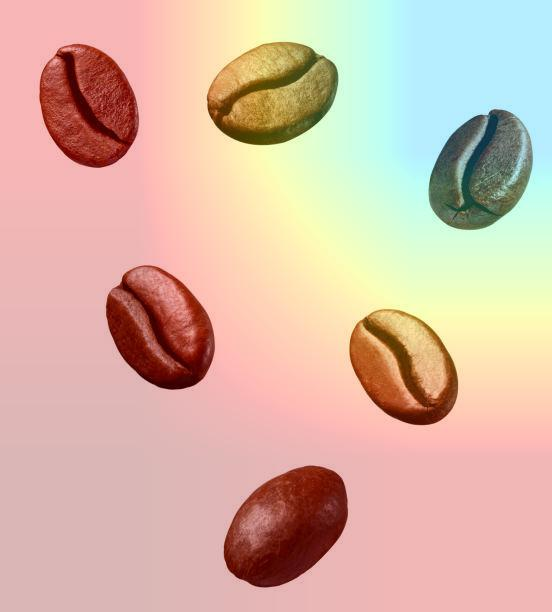

In [23]:
save_and_display_gradcam('cafe.jpg', heatmap1)